In [173]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [98]:
soup = BeautifulSoup(page.content, 'html.parser')
soup

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">

<html>
<head>
<style type="text/css">
<!--
  .body_background { background: white url(/images/background.jpg); background-repeat:no-repeat; background-position: top center; background-attachment:scroll; text-align:left; font-family:Helvetica,Arial,sans-serif; font-style:normal; font-weight:normal; font-size:10pt; color:black;  }
  .body_mobile_background { background: white url(/images/background.jpg); background-repeat:no-repeat; background-position: top center; background-attachment:scroll; text-align:left; font-family:Helvetica,Arial,sans-serif; font-style:normal;
font-weight:normal; font-size:10pt; color:black;  }
  .header_avherald { text-align:center; font-family:Times,Time New Roman,sans-serif; font-style:normal; font-weight:bold; font-size:32pt; }
  .subheader_avherald { text-align:center; font-family:Times,Time New Roman,sans-serif; font-style:normal; font-weight:normal;font-size:14pt; 

In [24]:
#finding next page
img = soup.find("img", {"title": "Next"})
img.parent.get('href')

'/h?list=&opt=0&offset=20190312204059%2B4c52281f'

In [138]:
#finding the accident classification
soup.findAll('span',{'class':'headline_avherald'})[0].parent.parent.parent.find('img')['title']

'Incident'

In [46]:
import re

In [25]:
#pull HTML from webpage and create BeautifulSoup object
def cook_soup(url): 
    webpage = requests.get(url)
    soup = BeautifulSoup(webpage.content, 'html.parser')
    return soup

In [147]:
def single_airline_parse(headline):
    regex = r"([A-Za-z0-9\s]+)\s([A-Z0-9]{1,5})\s(?:at|near)\s(.+)(?:\son\s)([A-Za-z0-9\s]+)(?:,\s)(.+)"
    groups = re.search(regex, headline)
    return groups

In [88]:
def double_airline_parse(headline):
    regex = r"([A-Za-z0-9\s]+)\s([A-Z]{1,5}[0-9]{1,5})\s(?:and)\s([A-Za-z0-9\s]+)([A-Z]{1,5}[0-9]{1,5})\s(?:at|near)\s(.+)(?:\son\s)([A-Za-z0-9\s]+)(?:,\s)([A-Za-z0-9\s]+)"
    groups = re.search(regex, headline)
    return groups

In [169]:
#function intakes the base url for website and the number of pages user would like to scrape,
#and outputs a list of headline dictionaries
def create_df(initial_url,num_pages):
    
    url = initial_url
    #empty list will hold each headline dictionary
    all_headlines = []
    
    #code will run for each page that needs to be scraped
    for page in range(1,num_pages+1):
        #creating BeautifulSoup object from scraped webpage
        soup = cook_soup(url)
        #narrow the HTML of soup to reference only the table of headlines
        table =  soup.findAll('span',{'class':'headline_avherald'})
        #find "Next" button and get the URL path associated
        next_page = soup.find("img", {"title": "Next"}).parent.get('href')
        
        #code will run for each headline in the table of headlines
        for report in table:
            #finding the incident class
            inc_class = report.parent.parent.parent.find('img')['title']
            #finding the headline as a long string
            headline = report.get_text()
            #skip cases with two airlines or two locations listed
            if ' and ' not in headline.partition(' on ')[0]:
                #run regex parser
                parsed_headline = single_airline_parse(headline)
                #if regex parser returns some value, create a headline dictionary of parsed strings
                if parsed_headline:
                    hl_dict = {}
                    hl_dict['Class'] = inc_class
                    hl_dict['Airline'] = parsed_headline[1]
                    hl_dict['Aircraft'] = parsed_headline[2]
                    hl_dict['Location'] = parsed_headline[3]
                    hl_dict['Date'] = parsed_headline[4]
                    hl_dict['Description'] = parsed_headline[5]
                    all_headlines.append(hl_dict)
        #update url with the path associated with the "Next" button
        url = initial_url+next_page
        
    return all_headlines
 
#                 if ' and ' in headline.partition(' on ')[0]:
#                     parsed_headline = double_airline_parse(headline)
#                     num_headlines = 2
#                 else:
#                     parsed_headline = single_airline_parse(headline)
#                     num_headlines = 1
#                 print(parsed_headline)
#                 for i in range(1,num_headlines+1):
#                     hl_dict = {}
#                     hl_dict['Class'] = inc_class
#                     if i == 1:
#                         hl_dict['Airline'] = parsed_headline[1]
#                     else:
#                         hl_dict['Airline'] = parsed_headline[3]
#                     hl_dict['Aircraft'] = parsed_headline[i*2]
#                     hl_dict['Location'] = parsed_headline[num_headlines*2+1]
#                     hl_dict['Date'] = parsed_headline[num_headlines*2+2]
#                     hl_dict['Description'] = parsed_headline[num_headlines*2+3]


In [170]:
df = create_df("http://avherald.com/",10)

In [172]:
len(df)

451

In [361]:
demo = pd.DataFrame(df)
demo.head()

,Aircraft,Airline,Class,Date,Description,Location
0,B738,Pobeda,Incident,Mar 23rd 2019,lightning strike,Sochi
1,B789,Aeromexico,Incident,Mar 23rd 2019,problem with cockpit oxygen,Lima
2,F100,Iran,Accident,Mar 19th 2019,main gear did not extend,Tehran
3,A332,American,Incident,Mar 22nd 2019,pack problem,Munich
4,B737,BoA,Incident,Mar 22nd 2019,engine shut down in flight,Cochabamba


In [380]:
demo.drop(57, inplace = True)

In [381]:
demo.describe()

,Aircraft,Airline,Class,Date,Description,Location
count,450,450,450,450,450,450
unique,69,222,5,174,294,277
top,A320,American,Incident,Feb 25th 2019,engine shut down in flight,Amsterdam
freq,56,20,375,11,32,12


In [382]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 450
Data columns (total 6 columns):
Aircraft       450 non-null object
Airline        450 non-null object
Class          450 non-null object
Date           450 non-null object
Description    450 non-null object
Location       450 non-null object
dtypes: object(6)
memory usage: 24.6+ KB


In [232]:
incidents = pd.DataFrame(df)

In [237]:
incidents[30:60]

,Aircraft,Airline,Class,Date,Description,Location
30,MD83,FAT,Incident,Mar 13th 2019,runway excursion while turning to backtrack,Kalibo
31,A20N,Indigo,Incident,Jan 21st 2017,rejected takeoff due to engine failure,Mumbai
32,B738,TUI Belgium,Incident,Feb 20th 2019,hydraulic failure,Ottawa
33,B763,Canada,Incident,Mar 4th 2019,pirouette on roll out,Halifax
34,D228,s Connection,Accident,Dec 18th 2018,nose gear did not extend,Sao Tome
35,B763,Delta,Incident,Mar 13th 2019,engine problem,Beijing
36,B763,United,Incident,Mar 12th 2019,flaps problem,Munich
37,B738,Transat,Accident,Mar 9th 2019,cargo smoke indication,Newark
38,B744,China Airlines,Incident,Mar 9th 2019,fuel emergency,Taipei
39,A320,Lao,Incident,Mar 10th 2019,nose gear steering fault after departure,Vientiane


In [245]:
incidents.drop(57, inplace = True)

In [246]:
incidents[30:60]

,Aircraft,Airline,Class,Date,Description,Location
30,MD83,FAT,Incident,Mar 13th 2019,runway excursion while turning to backtrack,Kalibo
31,A20N,Indigo,Incident,Jan 21st 2017,rejected takeoff due to engine failure,Mumbai
32,B738,TUI Belgium,Incident,Feb 20th 2019,hydraulic failure,Ottawa
33,B763,Canada,Incident,Mar 4th 2019,pirouette on roll out,Halifax
34,D228,s Connection,Accident,Dec 18th 2018,nose gear did not extend,Sao Tome
35,B763,Delta,Incident,Mar 13th 2019,engine problem,Beijing
36,B763,United,Incident,Mar 12th 2019,flaps problem,Munich
37,B738,Transat,Accident,Mar 9th 2019,cargo smoke indication,Newark
38,B744,China Airlines,Incident,Mar 9th 2019,fuel emergency,Taipei
39,A320,Lao,Incident,Mar 10th 2019,nose gear steering fault after departure,Vientiane


In [182]:
incidents['Aircraft'].value_counts().head(5)

A320    57
B738    55
A321    21
B763    18
B773    18
Name: Aircraft, dtype: int64

In [183]:
incidents['Airline'].value_counts().head(5)

American    20
Canada      14
Delta       13
United      11
Jazz         8
Name: Airline, dtype: int64

In [184]:
incidents['Date'][0]

'Mar 23rd 2019'

In [187]:
import datetime
import time

In [189]:
datetime_object = time.strptime(incidents['Date'][0].replace('rd',''), '%b %d %Y')

In [195]:
datetime_object.tm_year

2019

In [247]:
def convert_to_date(date):
    if 'rd ' in date:
        return date.replace('rd','')
    elif 'th ' in date:
        return date.replace('th','')
    elif 'nd ' in date:
        return date.replace('nd','')
    elif 'st ' in date:
        return date.replace('st','')

In [248]:
incidents['Date'] = incidents['Date'].map(convert_to_date)

In [249]:
def convert_to_datetime(date):
    return time.strptime(date, '%b %d %Y')

In [250]:
incidents['datetime'] = incidents['Date'].map(convert_to_datetime)

In [255]:
incidents['Year'] = [dt.tm_year for dt in incidents['datetime']]

In [261]:
incidents['Month'] = [dt.tm_mon for dt in incidents['datetime']]

In [269]:
day_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

In [270]:
incidents['Day'] = [day_dict[dt.tm_wday] for dt in incidents['datetime']]

In [348]:
incidents.head(20)

,Aircraft,Airline,Class,Date,Description,Location,datetime,Year,Month,Day
0,B738,Pobeda,Incident,Mar 23 2019,lightning strike,Sochi,"(2019, 3, 23, 0, 0, 0, 5, 82, -1)",2019,3,Saturday
1,B789,Aeromexico,Incident,Mar 23 2019,problem with cockpit oxygen,Lima,"(2019, 3, 23, 0, 0, 0, 5, 82, -1)",2019,3,Saturday
2,F100,Iran,Accident,Mar 19 2019,main gear did not extend,Tehran,"(2019, 3, 19, 0, 0, 0, 1, 78, -1)",2019,3,Tuesday
3,A332,American,Incident,Mar 22 2019,pack problem,Munich,"(2019, 3, 22, 0, 0, 0, 4, 81, -1)",2019,3,Friday
4,B737,BoA,Incident,Mar 22 2019,engine shut down in flight,Cochabamba,"(2019, 3, 22, 0, 0, 0, 4, 81, -1)",2019,3,Friday
5,A333,Cathay Pacific,Incident,Mar 22 2019,hydraulic failure,Jakarta,"(2019, 3, 22, 0, 0, 0, 4, 81, -1)",2019,3,Friday
6,B773,PIA,Incident,Mar 22 2019,bird strike penetrates leading edge of wing,Lahore,"(2019, 3, 22, 0, 0, 0, 4, 81, -1)",2019,3,Friday
7,A320,United,Incident,Mar 16 2019,duck!,Vancouver,"(2019, 3, 16, 0, 0, 0, 5, 75, -1)",2019,3,Saturday
8,B737,Southwest,Incident,Mar 21 2019,flock of birds on short final,Houston,"(2019, 3, 21, 0, 0, 0, 3, 80, -1)",2019,3,Thursday
9,A320,Jetstar,Report,Sep 20 2018,thrust reversers did not deploy,Sydney,"(2018, 9, 20, 0, 0, 0, 3, 263, -1)",2018,9,Thursday


In [378]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 450
Data columns (total 10 columns):
Aircraft       450 non-null object
Airline        450 non-null object
Class          450 non-null object
Date           450 non-null object
Description    450 non-null object
Location       450 non-null object
datetime       450 non-null object
Year           450 non-null int64
Month          450 non-null int64
Day            450 non-null object
dtypes: int64(2), object(8)
memory usage: 58.7+ KB


In [290]:
incidents.to_csv('avherald_march24.csv')

In [401]:
airlines = incidents['Airline'].unique()

In [403]:
airlines.sort()
airlines

array(['AIT', 'ANA', 'ANZ', 'ATA', 'Aeroflot', 'Aerolineas', 'Aeromexico',
       'Aeromexico Connect', 'Air Austral', 'Air China', 'Air France',
       'Alaska', 'Alitalia', 'Allegiant', 'Alliance', 'Alrosa',
       'American', 'Ameristar', 'Arabia Maroc', 'Argentinas', 'Atlas',
       'Austral', 'Austrian', 'Avianca', 'Avianca Ecuador', 'Azman',
       'Azul', 'Azur', 'Baltic', 'Bangla', 'Biman', 'BoA',
       'British Airways', 'Brussels', 'Bulgaria', 'CSA', 'Canada',
       'Canada Rouge', 'Cargolux', 'Cathay Dragon', 'Cathay Pacific',
       'China Airlines', 'China Southern', 'Comair', 'Commut',
       'Commutair', 'Compass', 'Condor', 'Conquest Cargo', 'Copa',
       'Creebec', 'Danu', 'Darwin', 'Delta', 'Easyjet', 'Edelweiss',
       'Emirates', 'Endeavor', 'Envoy', 'Ethiopian', 'Etihad',
       'Eurowings', 'Eva', 'Everts', 'Expressjet', 'FAT', 'First',
       'Flair', 'Fly Jamaica', 'Fly540', 'FlyEgypt', 'Flybe', 'Flybondi',
       'Flydubai', 'France', 'Frontier', 'Georgian'

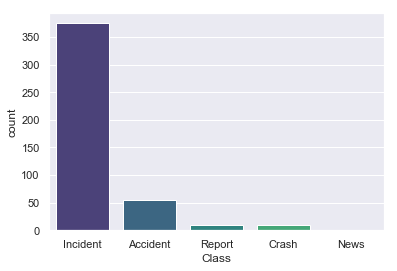

In [360]:
sns.countplot('Class',data=incidents,palette='viridis')

In [298]:
incidents['Class'].value_counts()

Incident    375
Accident     55
Report       10
Crash         9
News          1
Name: Class, dtype: int64

Text(0.5, 1.0, 'Headline Classification')

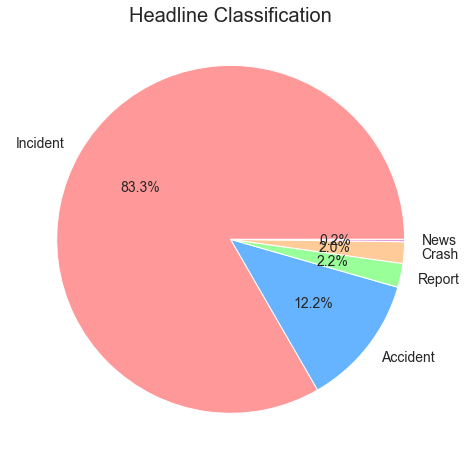

In [433]:
plt.figure(figsize=(8,8))
plt.pie(incidents['Class'].value_counts(),labels = incidents['Class'].unique(),autopct='%1.1f%%',colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','plum'],
textprops={'fontsize': 14})
plt.title('Headline Classification',{'fontsize': 20,'verticalalignment': 'center'})


In [315]:
incidents['Location'].value_counts()

Amsterdam          12
London             10
Toronto             9
Munich              8
Moscow              8
Vancouver           7
Rio de Janeiro      6
New York            6
Chicago             5
Dallas              5
Frankfurt           4
Mumbai              4
Boston              4
Sao Paulo           4
Hartford            4
Miami               4
Paris               4
Geneva              4
Brasilia            3
Fort Lauderdale     3
Lucknow             3
Taipei              3
Hong Kong           3
Osaka               3
Houston             3
Spokane             3
Guayaquil           3
Melbourne           3
Billund             3
Los Angeles         3
                   ..
Abidjan             1
Raleigh Durham      1
Dunedin             1
Alexandria          1
Orlando             1
Honolulu            1
Fath                1
Surgut              1
Guadalajara         1
North Pole          1
Anadyr              1
Seoul               1
Chania              1
Istanbul            1
Hamburg   

In [317]:
B738_df = incidents.query("Aircraft == 'B738'")

In [318]:
B738_df

,Aircraft,Airline,Class,Date,Description,Location,datetime,Year,Month,Day
0,B738,Pobeda,Incident,Mar 23 2019,lightning strike,Sochi,"(2019, 3, 23, 0, 0, 0, 5, 82, -1)",2019,3,Saturday
20,B738,FlyEgypt,Incident,Mar 17 2019,tail scrape on departure,Hurghada,"(2019, 3, 17, 0, 0, 0, 6, 76, -1)",2019,3,Sunday
25,B738,Alrosa,Incident,Mar 15 2019,electrical problems,Syktyvkar,"(2019, 3, 15, 0, 0, 0, 4, 74, -1)",2019,3,Friday
32,B738,TUI Belgium,Incident,Feb 20 2019,hydraulic failure,Ottawa,"(2019, 2, 20, 0, 0, 0, 2, 51, -1)",2019,2,Wednesday
37,B738,Transat,Accident,Mar 9 2019,cargo smoke indication,Newark,"(2019, 3, 9, 0, 0, 0, 5, 68, -1)",2019,3,Saturday
61,B738,Flybondi,Incident,Mar 4 2019,gear problem on departure,Buenos Aires,"(2019, 3, 4, 0, 0, 0, 0, 63, -1)",2019,3,Monday
65,B738,China Southern,Incident,Mar 5 2019,rejected takeoff due to engine and APU fire in...,Zhuhai,"(2019, 3, 5, 0, 0, 0, 1, 64, -1)",2019,3,Tuesday
71,B738,Qantas,Incident,Mar 5 2019,cabin pressure problems,Adelaide,"(2019, 3, 5, 0, 0, 0, 1, 64, -1)",2019,3,Tuesday
83,B738,THY,Incident,Feb 28 2019,hydraulic failure,Odessa,"(2019, 2, 28, 0, 0, 0, 3, 59, -1)",2019,2,Thursday
100,B738,American,Incident,Feb 26 2019,odour on board,Hartford,"(2019, 2, 26, 0, 0, 0, 1, 57, -1)",2019,2,Tuesday


In [319]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [332]:
airline_df = incidents.groupby('Airline')['Class'].count()
airline_df[airline_df >1]

Airline
ANA                  2
ANZ                  2
ATA                  2
Aeroflot             5
Aeromexico           4
Air China            2
Alaska               4
Allegiant            2
American            20
Atlas                2
Austral              2
Avianca              3
Azul                 3
Biman                2
BoA                  2
British Airways      7
Brussels             2
Canada              14
Cathay Pacific       4
China Airlines       2
China Southern       3
Delta               13
Easyjet              3
Emirates             2
Envoy                7
Ethiopian            5
Etihad               3
Eurowings            2
FlyEgypt             2
Flybe                6
                    ..
Pobeda               2
Qantas               3
Rusline              2
Ryanair              4
S7                   2
SA Airlink           2
Scoot                2
Singapore            2
Skywest              6
Smartwings           2
Southwest            7
Spicejet             2
Spi

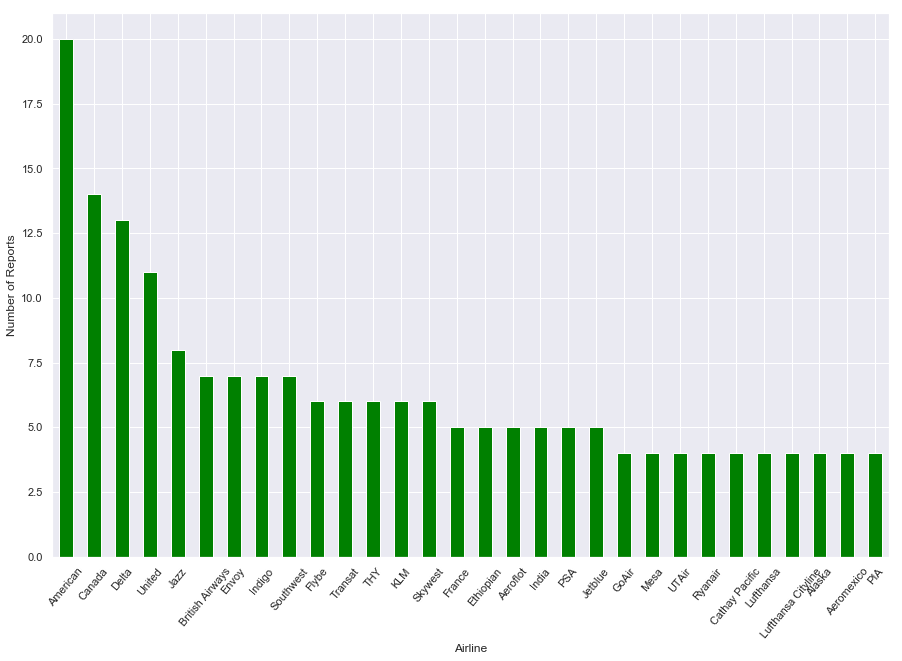

In [386]:
plt.figure(figsize=(15,10))
airline_df[airline_df>3].sort_values(ascending=False).plot.bar(cmap='ocean')
plt.xticks(rotation=50)
plt.xlabel("Airline")
plt.ylabel("Number of Reports")
plt.show()

Text(0.5, 1.0, 'Headlines per Airline')

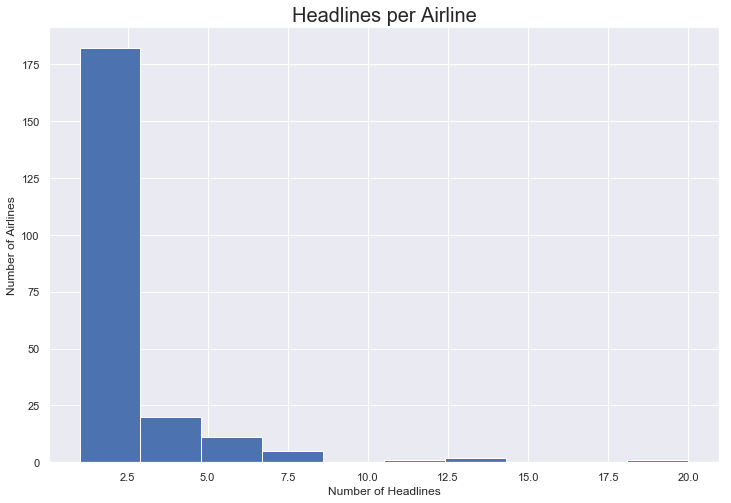

In [391]:
plt.figure(figsize = (12,8))
plt.hist(incidents['Airline'].value_counts())
plt.ylabel('Number of Airlines')
plt.xlabel('Number of Headlines')
plt.title('Headlines per Airline',fontsize=20)

In [393]:
incidents['Airline'].value_counts().head(5)

American    20
Canada      14
Delta       13
United      11
Jazz         8
Name: Airline, dtype: int64

Text(0.5, 1.0, 'Headlines per Aircraft')

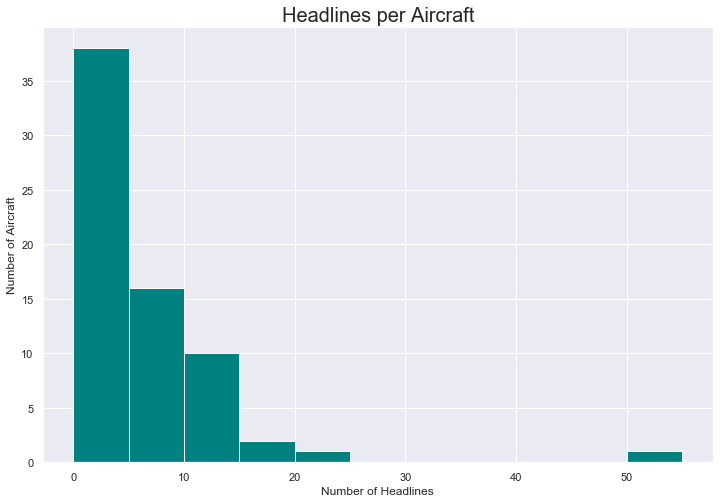

In [407]:
plt.figure(figsize = (12,8))
plt.hist(incidents['Aircraft'].value_counts(),color='teal',bins=list(range(0,60,5)))
plt.ylabel('Number of Aircraft')
plt.xlabel('Number of Headlines')
plt.title('Headlines per Aircraft',fontsize=20)

In [400]:
incidents['Aircraft'].value_counts().head(5)

A320    56
B738    55
A321    21
B763    18
B773    18
Name: Aircraft, dtype: int64

In [347]:
text = " ".join(descr for descr in incidents['Description'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 12301 words in the combination of all review.


In [357]:
stopwords = set(STOPWORDS)
stopwords.update(["problem", "failure","problems","shut down","flight"])

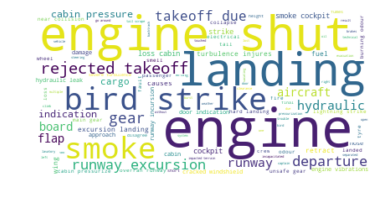

In [358]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords,max_words=100,background_color='white').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [359]:
wordcloud.to_file("all_descriptions_better.png")

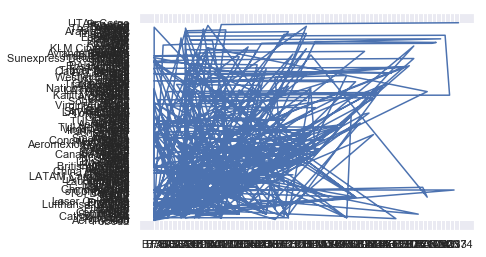

In [379]:
plt.plot('Aircraft','Airline',data=incidents)

In [383]:
incidents.tail(20)

,Aircraft,Airline,Class,Date,Description,Location,datetime,Year,Month,Day
431,E135,Envoy,Incident,Dec 13 2018,flaps problem,San Antonio,"(2018, 12, 13, 0, 0, 0, 3, 347, -1)",2018,12,Thursday
432,B738,Smartwings,Incident,May 29 2017,loss of cabin pressure,Kosice,"(2017, 5, 29, 0, 0, 0, 0, 149, -1)",2017,5,Monday
433,B773,Cathay Pacific,Incident,Dec 6 2018,rejected takeoff,Toronto,"(2018, 12, 6, 0, 0, 0, 3, 340, -1)",2018,12,Thursday
434,B737,Southwest,Incident,Dec 9 2018,heartfelt return,Seattle,"(2018, 12, 9, 0, 0, 0, 6, 343, -1)",2018,12,Sunday
435,B733,Peace,Incident,Dec 14 2018,loss of cabin pressure,Enugu,"(2018, 12, 14, 0, 0, 0, 4, 348, -1)",2018,12,Friday
436,A321,Ural,Accident,Dec 14 2018,tail strike on departure,Ufa,"(2018, 12, 14, 0, 0, 0, 4, 348, -1)",2018,12,Friday
437,DH8D,Flybe,Incident,Nov 15 2018,altitude disagree,Exeter,"(2018, 11, 15, 0, 0, 0, 3, 319, -1)",2018,11,Thursday
438,B738,Aeromexico,Incident,Dec 12 2018,radome damage on final approach,Tijuana,"(2018, 12, 12, 0, 0, 0, 2, 346, -1)",2018,12,Wednesday
439,B763,Canada,Accident,Dec 2 2018,turbulence injures three cabin crew,Ottawa,"(2018, 12, 2, 0, 0, 0, 6, 336, -1)",2018,12,Sunday
440,B734,Tailwind,Incident,Mar 11 2018,"""we have lost the cabin""",Sofia,"(2018, 3, 11, 0, 0, 0, 6, 70, -1)",2018,3,Sunday


In [385]:
incidents.groupby('Airline')['Aircraft'].count()

Airline
AIT                    1
ANA                    2
ANZ                    2
ATA                    2
Aeroflot               5
Aerolineas             1
Aeromexico             4
Aeromexico Connect     1
Air Austral            1
Air China              2
Air France             1
Alaska                 4
Alitalia               1
Allegiant              2
Alliance               1
Alrosa                 1
American              20
Ameristar              1
Arabia Maroc           1
Argentinas             1
Atlas                  2
Austral                2
Austrian               1
Avianca                3
Avianca Ecuador        1
Azman                  1
Azul                   3
Azur                   1
Baltic                 1
Bangla                 1
                      ..
Thai AirAsia           1
Thai Smile             1
Total Cargo            1
Trans Capital          1
Transat                6
Transavia              3
Travel Service         1
Tunis                  1
UPS              

In [408]:
incidents.query('Class == "Crash"')

,Aircraft,Airline,Class,Date,Description,Location,datetime,Year,Month,Day
12,B38M,Lion,Crash,Oct 29 2018,aircraft lost height and crashed into Java Sea...,Jakarta,"(2018, 10, 29, 0, 0, 0, 0, 302, -1)",2018,10,Monday
13,B38M,Ethiopian,Crash,Mar 10 2019,impacted terrain after departure,Bishoftu,"(2019, 3, 10, 0, 0, 0, 6, 69, -1)",2019,3,Sunday
22,DC3,Laser Colombia,Crash,Mar 9 2019,"engine failure, propeller could not be feathered",Villavicencio,"(2019, 3, 9, 0, 0, 0, 5, 68, -1)",2019,3,Saturday
43,B763,Atlas,Crash,Feb 23 2019,loss of control on approach,Houston,"(2019, 2, 23, 0, 0, 0, 5, 54, -1)",2019,2,Saturday
78,B703,Saha,Crash,Jan 14 2019,landed at wrong airport,Fath,"(2019, 1, 14, 0, 0, 0, 0, 14, -1)",2019,1,Monday
131,B772,Malaysia,Crash,Jul 17 2014,aircraft was shot down from separatist control...,Donetsk,"(2014, 7, 17, 0, 0, 0, 3, 198, -1)",2014,7,Thursday
144,AT72,Iran Aseman,Crash,Feb 18 2018,impacted terrain,Semirom,"(2018, 2, 18, 0, 0, 0, 6, 49, -1)",2018,2,Sunday
305,AT42,PIA,Crash,Dec 7 2016,engine failure,Havelian,"(2016, 12, 7, 0, 0, 0, 2, 342, -1)",2016,12,Wednesday
396,AN26,Gomair,Crash,Dec 20 2018,impacted terrain short of runway,Kinshasa,"(2018, 12, 20, 0, 0, 0, 3, 354, -1)",2018,12,Thursday


In [410]:
incidents.query('Aircraft == "B38M"')

,Aircraft,Airline,Class,Date,Description,Location,datetime,Year,Month,Day
12,B38M,Lion,Crash,Oct 29 2018,aircraft lost height and crashed into Java Sea...,Jakarta,"(2018, 10, 29, 0, 0, 0, 0, 302, -1)",2018,10,Monday
13,B38M,Ethiopian,Crash,Mar 10 2019,impacted terrain after departure,Bishoftu,"(2019, 3, 10, 0, 0, 0, 6, 69, -1)",2019,3,Sunday
122,B38M,Norwegian,Incident,Dec 14 2018,engine shut down in flight,Shiraz,"(2018, 12, 14, 0, 0, 0, 4, 348, -1)",2018,12,Friday
173,B38M,American,Incident,Feb 12 2019,hydraulic failure,San Juan,"(2019, 2, 12, 0, 0, 0, 1, 43, -1)",2019,2,Tuesday
220,B38M,TUI,Incident,Jan 29 2019,engine problem,Chania,"(2019, 1, 29, 0, 0, 0, 1, 29, -1)",2019,1,Tuesday
230,B38M,Argentinas,Incident,Dec 14 2018,engine vibrations as result of weather,Cordoba,"(2018, 12, 14, 0, 0, 0, 4, 348, -1)",2018,12,Friday
251,B38M,Canada,Incident,Jan 13 2019,rejected takeoff due to door indication,Palm Springs,"(2019, 1, 13, 0, 0, 0, 6, 13, -1)",2019,1,Sunday
261,B38M,Norwegian,Incident,Jan 18 2019,touched down despite go around instruction,Helsinki,"(2019, 1, 18, 0, 0, 0, 4, 18, -1)",2019,1,Friday
288,B38M,Canada,Incident,Dec 29 2018,failure of wing anti-ice,Vancouver,"(2018, 12, 29, 0, 0, 0, 5, 363, -1)",2018,12,Saturday
333,B38M,Spicejet,Incident,Jan 6 2019,engine shut down in flight,Varanasi,"(2019, 1, 6, 0, 0, 0, 6, 6, -1)",2019,1,Sunday


/Users/samantha/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


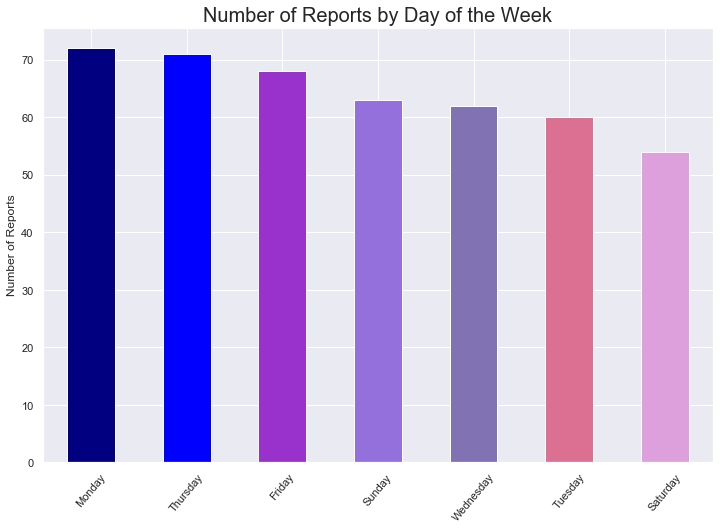

In [425]:
plt.figure(figsize=(12,8))
incidents['Day'].value_counts().plot.bar(colors=['navy','blue','darkorchid','mediumpurple','m','palevioletred','plum'])
plt.xticks(rotation=50)
plt.ylabel("Number of Reports")
plt.title('Number of Reports by Day of the Week', fontsize=20)
plt.show()